<a href="https://colab.research.google.com/github/Rbca0/Data-Science/blob/main/Copy_of_Unit6NotesAK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

# Unit 6: Multiple Generalized Linear Modeling

Last unit we learned how to predict a probalistic process using a different probablistic process--like using temperature to predict bike rentals.

This unit, we'll see what happens when we allow ourselves to use multiple predictors, instead of just one. This is more powerful, but also more challenging; we'll now have to decide what and how many predictors to use.

This process of variable selection is where causal diagrams really shine. Up till now, they have been a handy way to visualize how a model fits together.From here on out, causal diagrams will be a vital, dynamic part of the modeling process. They explain the concepts of Under/Overfitting, and help make our models moe interpretable.

We'll also play with categorical variables, heirarchies, and introduce interactions. These are all ways to discover the relationship between different predictors.

Here's what we'll cover, and the order we'll cover it in:
1. Multiple Linear Regression with pymc and model comparison
2. Regression with Bambi
3. Variable Selection
  - Causal Diagrams
  - elpd_loo
5. Distributional models (varable variance)
6. Categorical variables versus Hierarchies
7. Interactions

Let's dive in.

We'll spend most of this unit with the bikes data set, so that we can focus on the new concepts. I'll then throw in examples with other data sets once we've introduced all the new things

In [ ]:
bikes = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv')

In [ ]:
bikes

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0
...,...,...,...,...,...,...
343,90,9,4.22,0.48,0.3881,6
344,135,12,5.16,0.56,0.0896,1
345,13,15,4.22,0.87,0.3582,3
346,271,17,3.28,0.60,0.1343,5


## Multiple Linear Modeling with PyMC + Model Comparison with LOO

We will only use base PyMC for multiple linear modeling briefly. This is because multiple linear regression requires more plotting than simple linear regression, and bambi has some nice features for quickly and easily generating those plots.

We will use this oppurtunity to inroduce a new way to compare the performance of models: elpd_loo. This new method gives us a nice one number summary of which model is better, which is a useful tool to have when our models get two multidimensional to easily parse.

You've already seen the bikes model with temperature predicting rented. The model below is almost exactly the same.

In [ ]:
#nbb stands for negative binomial bike model
with pm.Model() as model_nbb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes.temperature))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=bikes.rented)

    #we need the log likelihood for model comparison later
    idata_nbb = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

In [ ]:
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

The model below is almost exactly the same.

In [ ]:
#mlb stands for multiple linear bikes
with pm.Model() as model_mlb:

    #priors on the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)

    #linear part of the model
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * bikes.temperature + β1 * bikes.hour))

    #prior for the standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=bikes.rented)

    #we need the log likelihood for model comparison later
    idata_mlb = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

In [ ]:
pm.sample_posterior_predictive(idata_mlb, model = model_mlb, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

**Task1**:

Looking only at the code, what's the difference between model\_nbb and model\_mlb?

**Answer1**:

There is a second predictor, bikes.hour, and a second slope to go along with it.

The difference is much more clear when I make a causal diagram representing each model

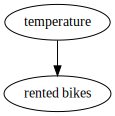

In [ ]:
#single predictor causal diagrm
dag_b = gv.Digraph(comment='bikes_dag') #b for bikes

dag_b.node('R', 'rented bikes')
dag_b.node('T','temperature')

dag_b.edges(['TR',])

dag_b

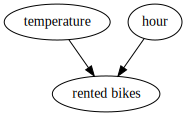

In [ ]:
#multiple predictor causal diagram
dag_b = gv.Digraph(comment='bikes_dag') #b for bikes

dag_b.node('R', 'rented bikes')
dag_b.node('T','temperature')
dag_b.node('H','hour')

dag_b.edges(['TR', 'HR',])

dag_b

Let's compare the two models' preformance using a ppc

<Axes: xlabel='y'>

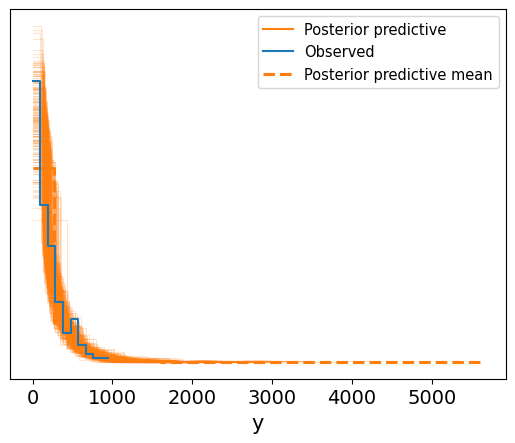

In [ ]:
az.plot_ppc(idata_nbb, num_pp_samples=200, colors=["C1", "C0", "C1"])

<Axes: xlabel='y'>

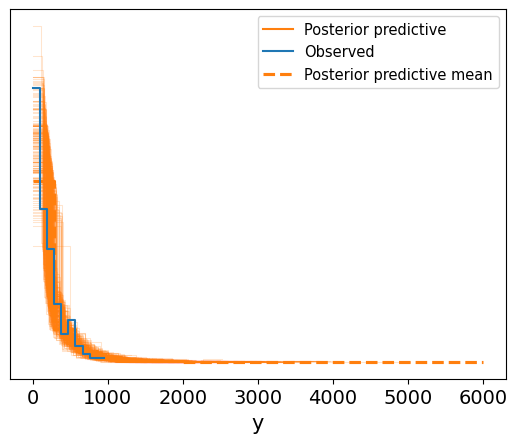

In [ ]:
az.plot_ppc(idata_mlb, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Task2**:

Describe any differences you can see.

**Answer2**:

model_mlb seems like its doing a little better predicting low bike count values, but I can't really tell

___________________________________________________________

Hopefully you're wondering if there is another way to compare these two models.

And there is!

The method is called Pareto Smoothed Importance Sampling Leave-One-Out Cross-Validation, which estimates the Expected Log-Pointwise-predictive Density.

We abbreviate all that with ELPD$_{LOO-CV}$, or elpd_loo, or even just LOO.

As the long full name implies, there are a lot of advanced, fancy tricks applied to the posterior to calculate LOO.

The important things to know:
- a more positive elpd_loo is better, but only in comparison to another model.
- the standard error (SE), sorta like the standard deviation, of elpd_loo helps tell us whether two models are significantly different than one another in terms of performance.
- There's something called a Pareto k diagnostic that tells us whether there were too many influential points for elpd_loo to be effective.



Let's look at the k diagnostic for the multiple linear model.

In [ ]:
az.loo(idata_mlb)

,0
elpd_loo,-2124.085024
se,23.375971
p_loo,4.303436
n_samples,2000
n_data_points,348
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


All 348 values in the bikes data set have a small enough influence that we can almost completely trust elpd_loo's recommendation.

We also get the value of elpd_loo (-2124.37), and its standard error (23.36). A more positive elpd_loo is better--But these are still useless without another model to compare them too.

Why? Because maybe the process that generated the data is intrisically hard to predict. In other words, maybe even the best model does pretty bad (a great example of this is the stock market). We won't know if that's the scenario we're in until we be *at least* one more model.

We do have another model to compare though! And arviz has some nice functions that will make the comparison trivial.

Here's the table version, which I think is less useful that the visualization below it.

The table does indclude info about a  warning though which is useful. As long as it says False, we're good--False means our k diagnostic was good enough. The other interesting entry is weight. This can be used to average the models being compared, using the following code:

```
idata_w = az.weight_predictions([idata_mlb,idata_nbb], weights=[0.903435, 0.096565])
```

We won't ever combine models like that though, even though it is a neat trick.


In [ ]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"multi_lin":idata_mlb,"single_lin":idata_nbb} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-2124.085024,4.303436,0.000000,0.910373,23.375971,0.00000,False,log
single_lin,1,-2153.350760,2.911004,29.265736,0.089627,19.811964,8.17239,False,log


elpd_loo and se are easier to understand using the graph below.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

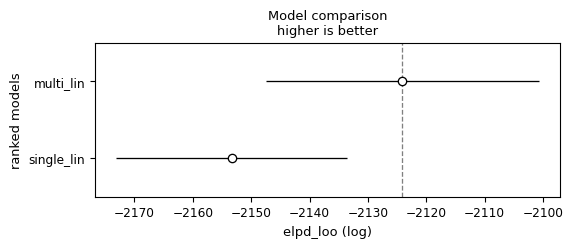

In [ ]:
az.plot_compare(cmp_df)

**Task3**:

Using the model comparison plot, which model would you pick? Why?

**Answer3**:

I'd probably pick the multiple linear model, especially if I needed to pick just one, and do no model averaging or combining.

But the overlapping standard error bars means that either model will perform similarly for predictive purposes. There isn't a clear winner between the two.

**NOTE**: elpd_loo is *NOT* the definitive say on which model is better. You MUST take conext into account. This is done formally by referencing the causal diagram, and deciding which casual diagram is a better map to reality.

Review the causal diagrams for each model. Which seems more realistic?

One final comment for this section: elpd_loo is basically a summary of the posterior predictive check. If one of your models has a clearly better posterior predicitve check based on visual, you do not need to bother with elpd_loo. We calculate elpd_loo when we feel like our visual inspection isn't enough.

## Bambi is Best
For (generalized) linear models, anyway.

Bambi is library for building bayesian (generalized) linear models.

Here are the two main two reasons to love bambi:

- by auto assigning normal and half normal priors with mean 0 and sd 1, bambi models are fast to write and read.
- it has built in methods for plotting the posterior means and posterior predictive distribution. No more giant blocks of code to create plots for linear models!

Here are the two main reasons to be cautious with bambi:

- it only works with (generalized) linear models. As in, using bambi means that we are assuming some type of linear model.
- bambi auto assigns normal and half normal priors with a mean of 0 and sd of 1. This isn't that big a deal, since there's a quick way to feed the priors we want into bambi. Its easy to get lazy with bambi, which is fine, until it isn't.

Colab also doesn't have bambi preinstalled, so we need to install it each time we pull up colab.

We will also need to install the latest version of xarray, since bambi relies on its latest features.

Note that you may get prompted to restart the session, especially if you've already run pymc and/or arviz. Go ahead and do so, if prompted.

In [ ]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
import bambi as bmb

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

### Linear Bikes + Regularizing Priors

Let's start by remaking the two bike models from earlier in the unit, but with bambi.

We'll also discuss the concept of regularizing priors; specifically, we'll see the the weakly informative priors bambi defaults too oftenn work great in practice.

#### Bambi bikes (1 predictor)
We'll start with the single variable model.

In [ ]:
#we put the priors that aren't normal or half normal with mean 0 and sigma 1
#in a dict
priors ={"temperature" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}

#This creates a skeleton of the model; it hasn't run MCMC or created a posterior yet
model_nbb_bmb = bmb.Model("rented ~ temperature", bikes, family = "negativebinomial", priors=priors)

In [ ]:
model_nbb_bmb

       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            temperature ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            alpha ~ HalfNormal(sigma: 10.0)

The 'family' argument in bmb.Model() is what determines both our likelihood and our link function. Bambi has default link functions that work well with families of likelihoods. Note the mu = log(x) is the same as exp(mu)=x.

Specifiying 'family' is optional; the default is a normal likelihood.

Also notice that defining the model only takes two lines of code, and we only need one more to make the model itself.

In [ ]:
#this is bambi's equivalent of pm.sample()
idata_nbb_bmb = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Two more lines gives us a plot of the posterior mean.

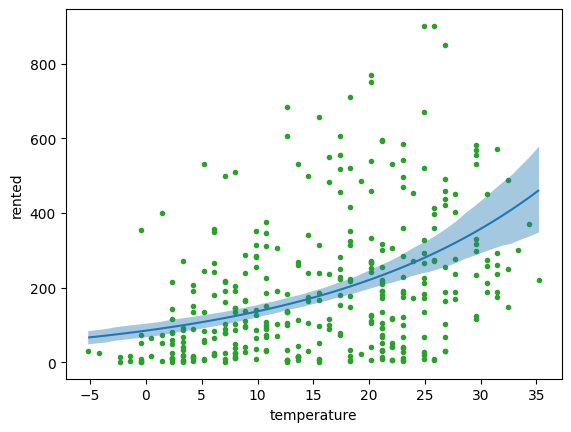

In [ ]:
bmb.interpret.plot_predictions(model_nbb_bmb, idata_nbb_bmb, "temperature")
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

A final two lines give us the posterior predictive distribution.

**The visualization below is what we will use to assess our models performance. It is a posterior predictive check, and thus can be used to compare models.**

In both graphs, the shaded blue area is a 94% HDI. You can change this by using the prob argument in the plot_predictions method.

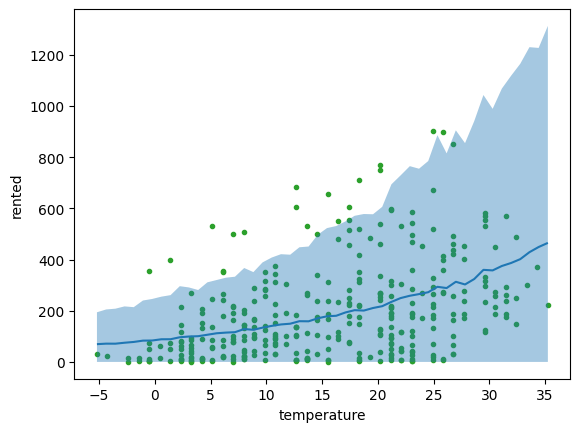

In [ ]:
#note the 'pps=True' argument added in to get a full posterior predictive check
bmb.interpret.plot_predictions(model_nbb_bmb, idata_nbb_bmb, "temperature", pps=True)
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

If you want the one dimentional posterior predictive check from before, you can get it with the following code:

<Axes: xlabel='rented'>

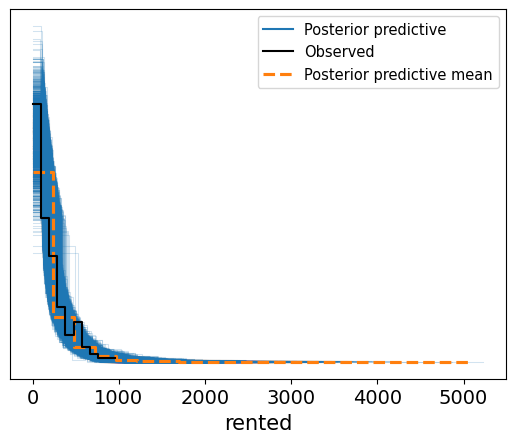

In [ ]:
model_nbb_bmb.predict(idata_nbb_bmb, kind="response")
az.plot_ppc(idata_nbb_bmb)

#### Regularizing Priors (weakly informative priors)

We do not have to specify priors get a bambi model to run; bambi has a routine to determine the priors based off the raw data. Remember, that's the same strategy I told you to employ when you needed to specify prior(s) for which you had no context.

So, if you're handed data you know next to nothing about, you can safely selected a likelihood, and fire the model up.

But if you do have an understanding of the context, your final model should reflect your knowledge in its priors.

In [ ]:
#notice that the priors argument isn't specified
model_nbb_bmb_regpriors = bmb.Model("rented ~ temperature", bikes, family = "negativebinomial")
idata_nbb_bmb_regpriors = model_nbb_bmb_regpriors.fit(idata_kwargs={"log_likelihood":True})

Output()

If you do let bambi select priors for you, then you must print out the model, to see what it selected. That way, you can check if its selections jive with your inuition.

In [ ]:
model_nbb_bmb_regpriors

       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9184)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Let's see the posterior mean and posterior predictive.

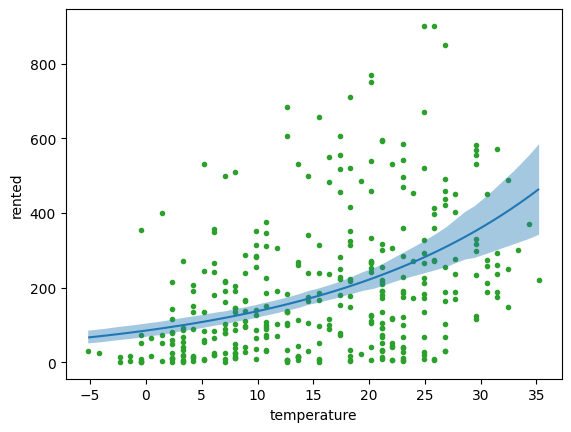

In [ ]:
bmb.interpret.plot_predictions(model_nbb_bmb_regpriors, idata_nbb_bmb_regpriors, "temperature")
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

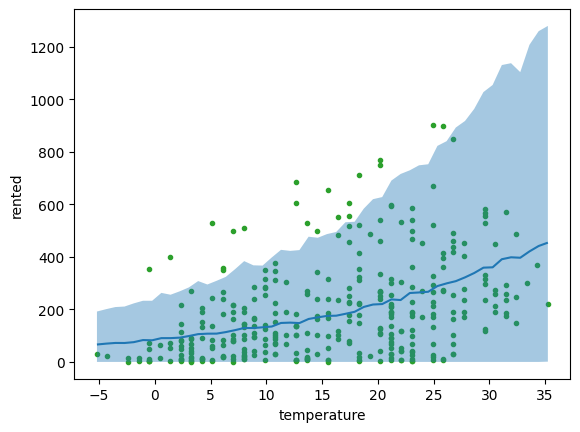

In [ ]:
bmb.interpret.plot_predictions(model_nbb_bmb_regpriors, idata_nbb_bmb_regpriors, "temperature", pps = True)
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

**Task4**:

Are their any significant differences in the graphs of model_nbb_bmb and model_nbb_regpriors?

Why or why not?

**Answer4**:

There are basically no differences. Two reasons:
- The priors we specified were not that different from the ones bambi chose.
- Even if they had been that different, there's enough data to overwhelm most reasonable priors. We'd need a strong set of priors to affect a model with over 300 data points. Remember, as our data grows to infinity, all models, regardless of prior converge.*

*unless your prior is 0, or something equally asinine.

#### Bambi bikes (multiple predictors)

Now that we know what a regularings prior is, and why they're often good enough let's recreate the model with both temperature and hour.

And since I was using the data to create my priors anyway, I let bambi choose my priors.

In [ ]:
model_mlb_bmb = bmb.Model("rented ~ temperature + hour", bikes, family="negativebinomial")
idata_mlb_bmb = model_mlb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

I need to print the model, so I can see what priors bambi went with.

In [ ]:
model_mlb_bmb

       Formula: rented ~ temperature + hour
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 6.4428)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
            hour ~ Normal(mu: 0.0, sigma: 0.3615)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Let's visualize the model, so we can actually see what it suggests.

(<Figure size 640x480 with 24 Axes>,
 array([[<Axes: title={'center': 'hour = 0'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 1'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 2'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 3'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 4'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 5'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 6'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 7'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 8'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 9'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 10'}, xlabel='temperature', ylabel='rented'>,
         <Axes

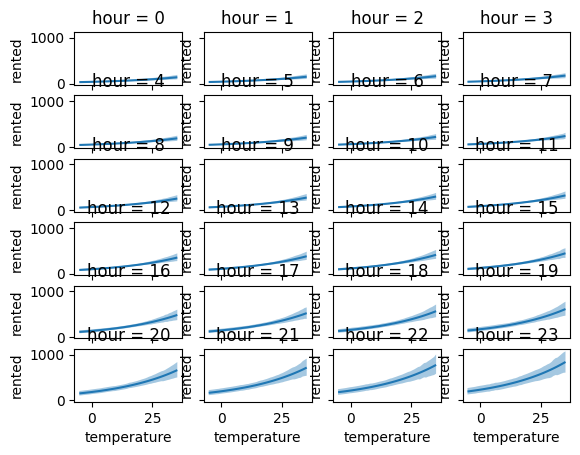

In [ ]:
bmb.interpret.plot_predictions(model_mlb_bmb, idata_mlb_bmb, ["temperature", "hour"],
                               subplot_kwargs={"group":None, "panel":"hour"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})

**Task5**:

Describe the relationship between the slope of temperature and the hour of the day, in model_mlb_bmb.

**Answer5**:

The slope of temerature increases as the hour increases. Additionally, the variance of the mean seems to increase as hour increases.

This is more obvious if you plot the posterior predictive distribution.

(<Figure size 640x480 with 24 Axes>,
 array([[<Axes: title={'center': 'hour = 0'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 1'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 2'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 3'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 4'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 5'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 6'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 7'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 8'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 9'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 10'}, xlabel='temperature', ylabel='rented'>,
         <Axes

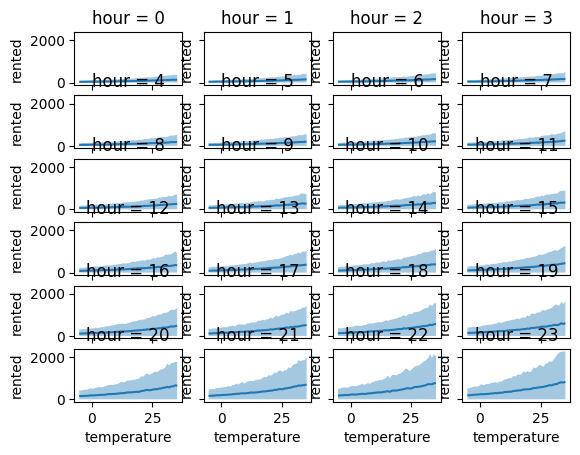

In [ ]:
#ANSWER5 cont.
bmb.interpret.plot_predictions(model_mlb_bmb, idata_mlb_bmb, ["temperature", "hour"],
                               subplot_kwargs={"group":None, "panel":"hour"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True},pps=True)

Bambi models are equally compatible with arviz, since they are running pymc under the hood. This means everything we learned about elpd_loo still applies.

In [ ]:
cmp_df_bmb = az.compare( {"multi_lin":idata_mlb_bmb,"single_lin":idata_nbb_bmb} )
cmp_df_bmb

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-2123.825134,4.098712,0.000000,0.936942,22.872581,0.000000,False,log
single_lin,1,-2152.904708,2.575416,29.079574,0.063058,19.520494,7.784637,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

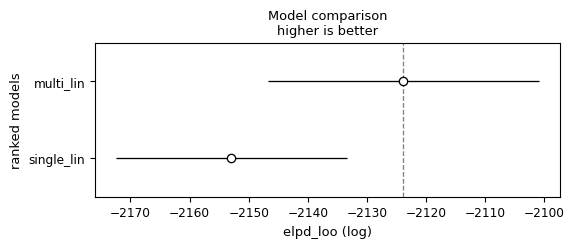

In [ ]:
az.plot_compare(cmp_df_bmb)

## Variable Selection

When using multiple predictors, some logical questions arise:
- do we really need multiple predictors?
- if so, how many do we need?
- and which ones? Are some better than others? The same as others?

The process of answering those questions is known as variable selection.

**Task6**:

Given what you know and what we've learned thus far, how would you go about selecting which variables are best?

**Answer6**:

The answer is to draw a causal directed acyclic graph (DAG), or causal diagram.

Causal diagrams help us define our assumptions about the casual relationships between variables. This in turn helps us define what variables are important to include and exclude from a model.

We covered causal diagrams in the past two units in the hopes that they would seem a natural solution to our current problem. Often--as in, almost everytime--the fastest way to pick the most realistic and performative model is to sit down with a pen and paper, and draw out a causal diagram that makes sense in context.

This is the reason we've drawn causal graphs without distributions and priors in them; priors can be distracting when we want to focus on variable selection. As you've seen in previous units, we start by thinking about just the data, then we think about priors.

Once we've done that, we need to do it again, so that we have at least one other model.

Then, I can assess my models' performance using elpd_loo and regular posterior predictive checks (ppc).

Finally, I have to decide which model is the best combination of performative and realistic. With bayesian models (which we exclusively use) the most performative model is often also the most realistic--but not always. We cannot *just* trust the numbers. We must always take context into consideration.

**Task7:**

Make a causal diagram for the bikes data context that is, in your opinion:
- the most performative
- the most realistic

Then, justify why it is realistic with typed text.

Finally, justify why it is performative using elpd_loo. Note that this requires reference to *at least* one other model.

**Ans7**:


In [ ]:
bikes.head()

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0


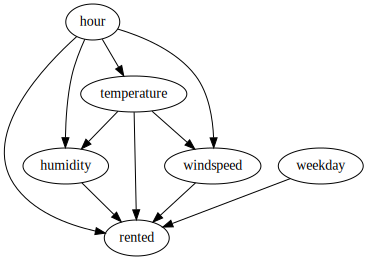

In [ ]:
b_dag = gv.Digraph(name="Bikes DAG")

b_dag.node('R','rented')
b_dag.node('T','temperature')
b_dag.node('H','hour')
b_dag.node('U','humidity')
b_dag.node('W','windspeed')
b_dag.node('D','weekday')

b_dag.edges(['TR','HT','TW','WR','HR','DR','HU','TU','HW','UR'])

b_dag


Justification:

- I assume all the variables have at least some causal effect on the number of rented bikes, hence all the nodes pointing to to rented
- hour is basically a measure of sunlight; the sun affects moisture in the air, temperature, and the wind
- temperature is heat in the air, or air wiggles; how much the air wiggles affects how much water the air holds, and larger air movement patterns (wind)
- weekday has nothing to do with anything; it only exists in our heads

Like all causal diagrams, this is a collection of assumptions. I'm fairly confident in these assumptions, with teh following caveats that are NOT visible in the graph above.

- hour and temperature likely have the strongest causal effect, at least in my mind.
- I bet the effect of humidity and windspeed are negilible, since most people don't check those when planning their day.

Now that I've laid out all my assumptions, I will not only make a model that includes all my assumptions, but also other models, to see how wrong I might be.

Here's the model that matches my causal diagram. The parts at the end with colons and multiple variables are called interactions, and they are one way of interpreting the arrows between predictor variables.

Don't worry about them for now, we'll get to them a little later this unit.

In [ ]:
model_bikesallinter = bmb.Model(
    "rented ~ temperature + hour + humidity + windspeed + weekday + hour:temperature + hour:humidity + hour:windspeed + temperature:humidity + temperature:windspeed",
    bikes, family="negativebinomial")
idata_bikesallinter = model_mlb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

The model has all the variables, but no interactions.

In [ ]:
model_bikesall = bmb.Model("rented ~ temperature + hour + humidity + windspeed + weekday", bikes, family="negativebinomial")
idata_bikesall = model_mlb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

I now compare all four models I've made:
- the interactions one that matches my diagram
- the one with all variables
- the model with just temperature as a predictor
- the one with temperature and hour

In [ ]:
cmp_df = az.compare(
    {"temp+hour":idata_mlb_bmb,"temp_only":idata_nbb_bmb_regpriors,"all":idata_bikesall,"all+inter":idata_bikesallinter} )
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
temp+hour,0,-2123.825134,4.098712,0.000000,9.377750e-01,22.872581,0.000000,False,log
all,1,-2124.008870,4.321375,0.183736,6.513278e-17,22.859168,0.041177,False,log
all+inter,2,-2124.085640,4.449232,0.260506,0.000000e+00,22.910495,0.058296,False,log
temp_only,3,-2153.053522,2.688337,29.228388,6.222497e-02,19.485940,7.787066,False,log


No warnings, so I can be confident in the next plot

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

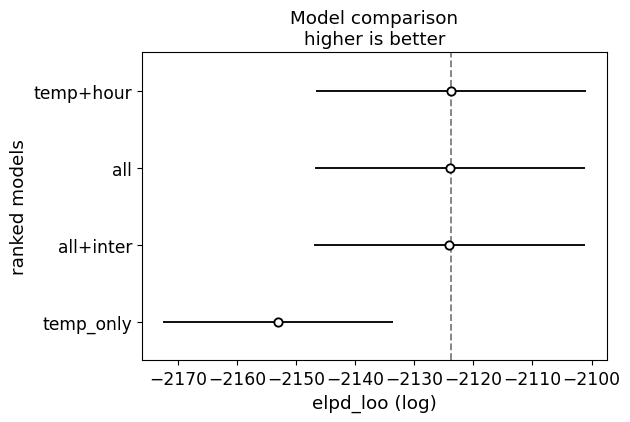

In [ ]:
az.plot_compare(cmp_df)

Based on this plot, it looks like hour and temperature are the only variables that we need to predict rented well.

Why do I say that? The temp only model is not clearly worse (the error bars overlap), but its enough that its not quite a tie either. I wouldn't choose it.

The others are tied though. I'd even consider them tied if the error bars of one where over the "mean dot" for another, but these are closer than that even.

In case of a tie, we usually pick the simplest model, which is the one with temperature and hour only. We can overrule that maxim if we think our causal diagram (our assumptions/knowledge of context) is especially robust.

But in this case, I already expected windspeed and humidity to be negilible, and while I didnt state this, I'm only a little surprised the weekends didn't change much.

All that said, we should now check to make sure we need both hour and tempreature.

In [ ]:
model_bikeshour = bmb.Model("rented ~ hour", bikes, family="negativebinomial")
idata_bikeshour = model_mlb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

In [ ]:
cmp_df = az.compare(
    {"temp+hour":idata_mlb_bmb,"temp_only":idata_nbb_bmb_regpriors,"all":idata_bikesall,"all+inter":idata_bikesallinter,"hour_only":idata_bikeshour} )

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

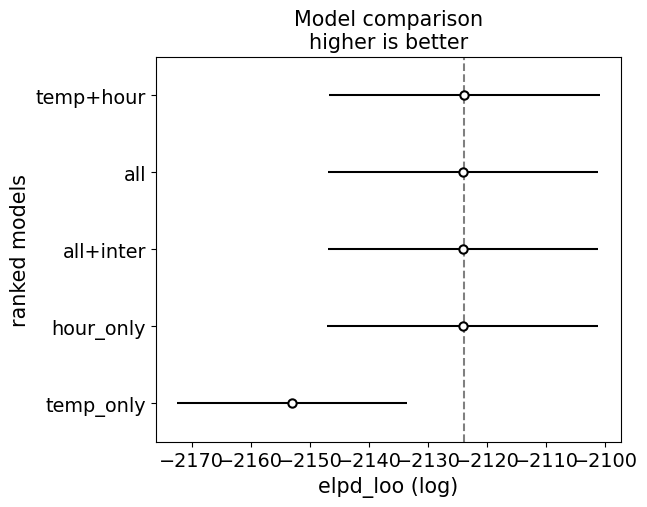

In [ ]:
az.plot_compare(cmp_df)

Well look at that.

Turns out hour is all we need to predict rented well.

My guess as to why this is true: for the city this data is collected from, I bet commuters (people going to work) make up the vast majority of users.
People go to work regardless of how nice a day it is outside.

A nice follow up analysis would likely involve adding in precipitation data, and maybe comparing to a city with a known strong tourism industry.

___________________________________________________________________________

#### Pair plots/Scatter plot Matricies

Before I mention how to make an interpret pair plots/scatter plot matricies, know that the comibnation of casual diagrams and the posterior predictive distributions of bayesian models (or their summaries using elpd) is the best way to "analyze data" as of this writing.

In order to help us figure out what bayesian model to contruct, and what casual diagram to draw, it often helps to plot each variables agaisnt one another.

We do this using a scatter plot matrix, or pair plot (a plot for each pair of variables).

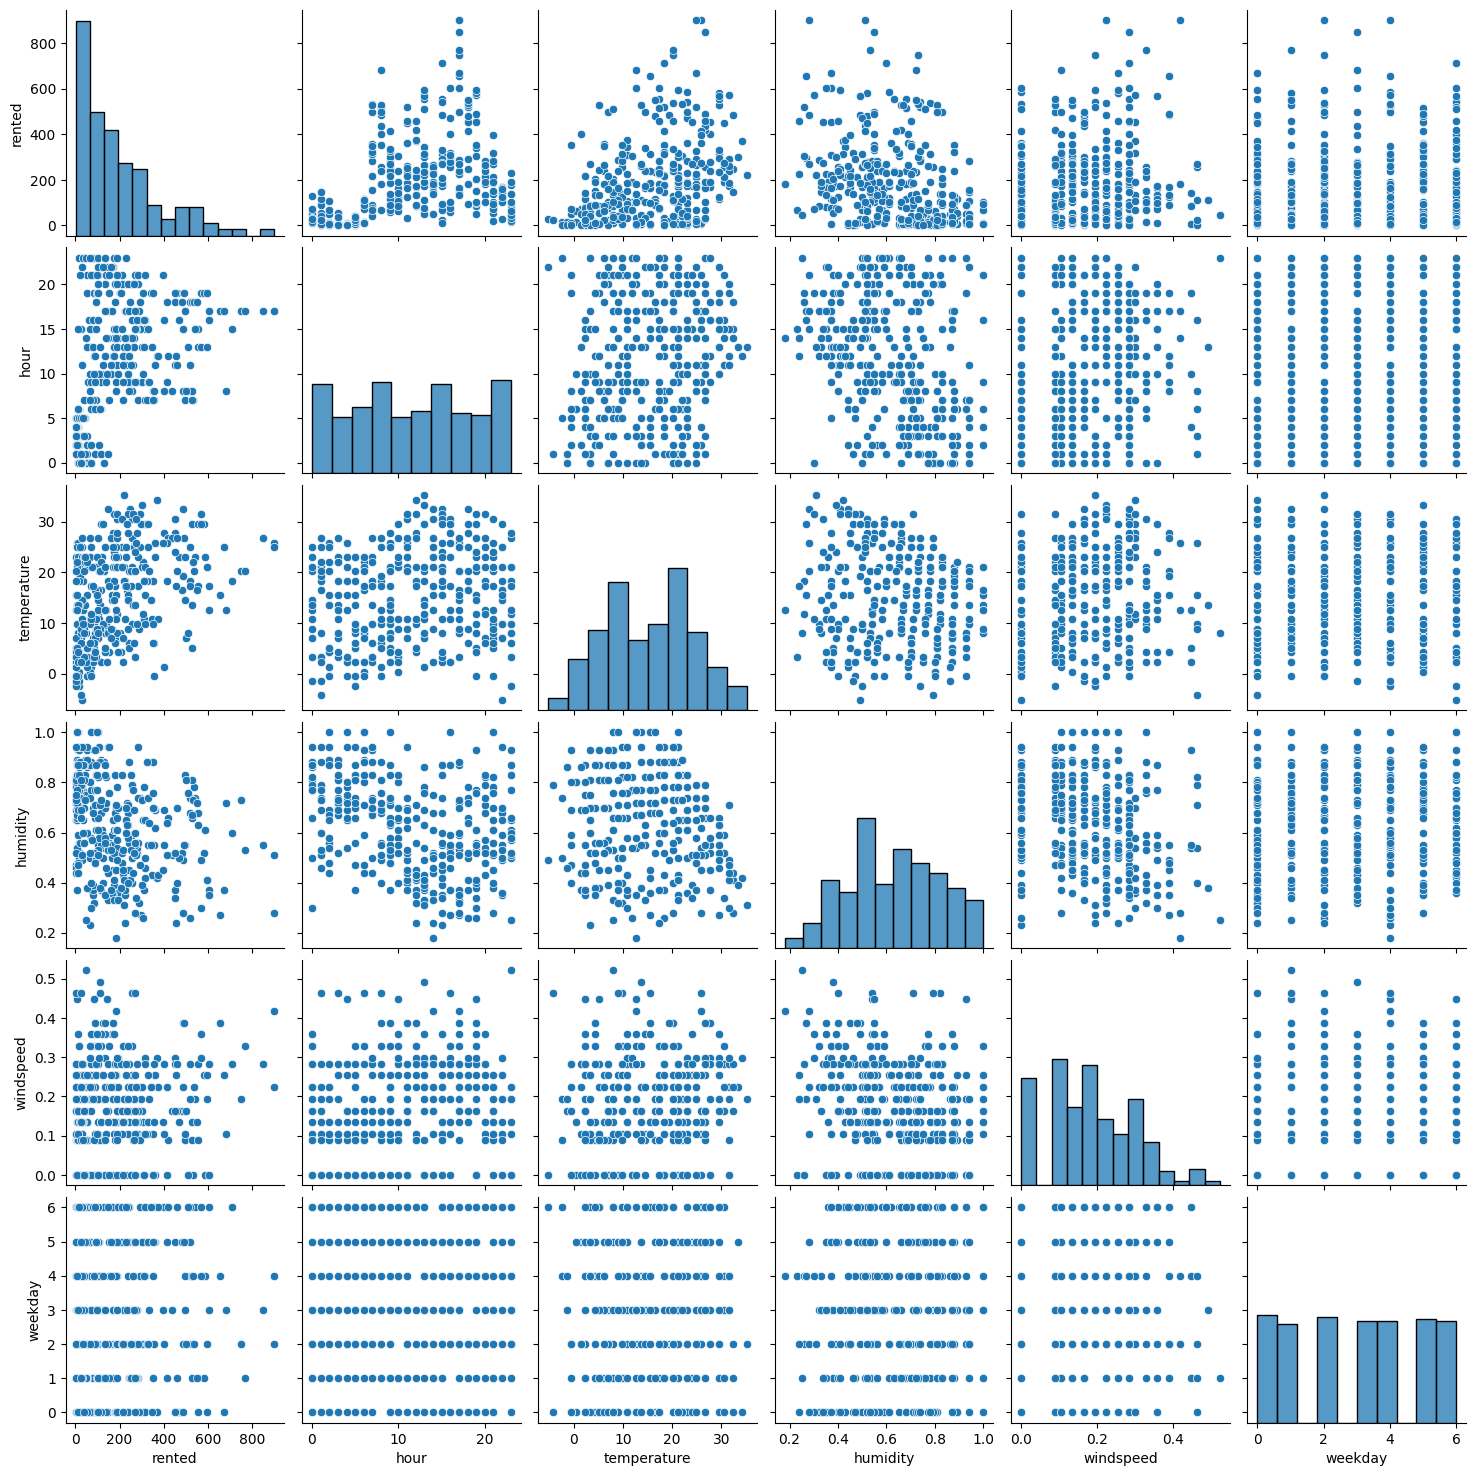

In [ ]:
sns.pairplot(bikes)

This is literally all possible scatter plots you can make with your dataframe.

**Task**:

How could we have used this scatter plot matrix/pair plot to help us draw our casual diagram--or even to reason out that hour is the only variable of interest, at least in this dataset?

**Ans**:

Look at the top row, which has rented on the vertical axis, and all the other variables on the horizontal.
Hour and temperature seem to follow the same pattern when plotted agaisnt rented.

Additionally, look at row 3, column 2. There is the slightest of positive trends--likely, we decided, because hour is a measure of the sun heating things up.

Note that the scatter plot itself only suggests that hour and temperature follow the same pattern, and seem to have an association.
My interpretation of that as "hour is a proxy for the sun" is a casual (as in casual diagram) assumption , and cannot be gleamed from the pairplot alone.

The other variables seem to have no notable patterns, with the exception of humitity. Temperature and humidity seem to have a nonlinear relationship, and high humidity does look like its associatied with lower rented.

Maybe if we had more observations/data, the pattern would become stronger, and our models would take it more seriously. Or perhaps the way the variables interact together in high dimensions nullifies its affects. There's actually another option as well: we could add an interaction term to see if that addes predictive power. More on interactions later in this unit.

NOTE: Pairplots are NOT objective. Objectivity isn't real.

Even if there do not seem to be strong trends in the pair plot, run a quick model anyway, and get a visual of a posterior predictive.

Pairplots only look at pairs of variables, or in 2 dimensions; something interesting might happen in higher dimensions (more variables at once). Usually, the pairplot is a good indicator of when there are patterns in the data--but "usually" is not all the time, and the exceptions are almost always interesting.

### Things to Know Variable Selection:

Our defaults:
1. Make a casual diagram, and a model based on that causal diagram. Use a pair plot to help guide you--but don't let it dicate all your decisions.

2. Make a "reference model" with as many available variables as possible in it.

3. Compare the posterior predictve distributions of each, and the elpd_loo while you're at it. This is the *minimum* amount of steps you should do.
    - You only stop here if the posterior predictive of your causal diagram inspired model looks spectacular--and even then, you should consider doing the next steps.

4. Start making models with less variables than the causal diagram inspired model and/or reference model--whichever was more performative in the previous step.

5. Compare the new models to your previous models. If you have any that do better with less variables, then make new ones with even less variables. See how low you can go without sacrificing performance.

6. Pick the best performing model with the lowest number of variables. Make a causal diagram for the model, if you have not already done so.

7. Compare that causal diagram to your originial diagram, and decide which one is more realistic. The models' performacne--posterior predictive visualization, elpd_loo--should influence your decision.

8. You now have your final model, the one that best predicts reality and best explains the causal relationships in reality, at least accoring to your analysis, and your data.

Why do we have a bias towards models with fewer variables? For now, we want to be more wary of overfitting than underfitting.

Overfitting is when our model seems to predict the data we have on hand well--but those predictions don't generalize to new, similar data. In other words, our model over fits the curve of the data, and doesn't allow enough room to adapt to the inherent variation in reality.

Underfitting is when we could have made better predictions, but our model is not complex enough to make the right predictions. Its easy to underfit with a GLM, but in the next three units we will learn new techniques which will make underfitting unlikely, to put it generously.

I want y'all to get in the habit of slowing your enthusiasm to make the curve fit as best as possible. We don't want to fit the curve, we want to make predictions that will help improve our decision making. Fitting the curve is a means to an end, a tool that can break, just like any other tool.



#### More Nuance on Bambi, Overfitting, and Regularizing Priors

Technically, the regulizing priors that bambi selected based on the data go a long way to making sure our predictions won't be too bad on new data, even if we include an extra few variables.

I'll say that again: weakly informative, or regularizing, priors do a lot to prevent overfitting. Priors are pretty much *the* way to help prevent overfitting.

In fact, having a bias towards models with less variables can itself be constructed as a prior. We're not going to make our preference that explicit, but the point is that we could.

The reason we won't make it that explicit, is that we want variable selection to be fluid. If we think an extra variable or two could capture information that happened to not be in this data set, then by all means, use your contextual knowledge to selcect a model with more variables.

This is especially true if our causal model includes lots of variables, and we our confident in our causal model.

However, if we know that collecting data on more variables is expensive or dangerous, then we can select a smaller model.

Variable selection is complicated. **You must draw a causal diagram**, calculate elpd_loo, compare to another model, adjust accordingly, and then repeat that process until you end up with something you believe in.

## Distributional models: Dealing with variable variance

We'll now take a quite detour back to single predictor land, so that I can show you how to account for variable variance with bambi.

When we build a linear regression model, there is at least one linear equation applied in our formulas--usually to the location/center parameter of our likelihood, which we've been calling mu.

Applying a linear equation to more than one parameter of our likelihood is called a distributional model. We've done this before with the babies dataset. We'll do it again now, but use bambi.


In [ ]:
babies = pd.read_csv("https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/babies.csv")

In [ ]:
#we need to specify the two distribution's relationships with a bambi method
formula_babies = bmb.Formula(
    "length ~ np.sqrt(month)",
    "sigma ~ month"
)

#dis for distributional model
model_dis = bmb.Model(formula_babies, babies)

#I only need "idata_kwargs={"log_likelihood":True}"" if I'm going to use
#elpd_loo for variable selection. So I could have dropped it here
idata_dis = model_dis.fit(idata_kwargs={"log_likelihood":True})

Output()

Here's how to get the kruschke diagram as well. I didn't do this with the bikes models because this function breaks when the likelihood is a negative binomial.

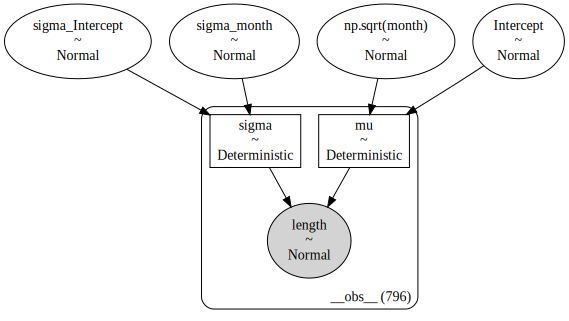

In [ ]:
model_dis.graph()

In [ ]:
#shows me what priors/likelihood bambi used.
model_dis

       Formula: length ~ np.sqrt(month)
                sigma ~ month
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 796
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 72.5125, sigma: 72.0827)
            np.sqrt(month) ~ Normal(mu: 0.0, sigma: 21.3849)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_month ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

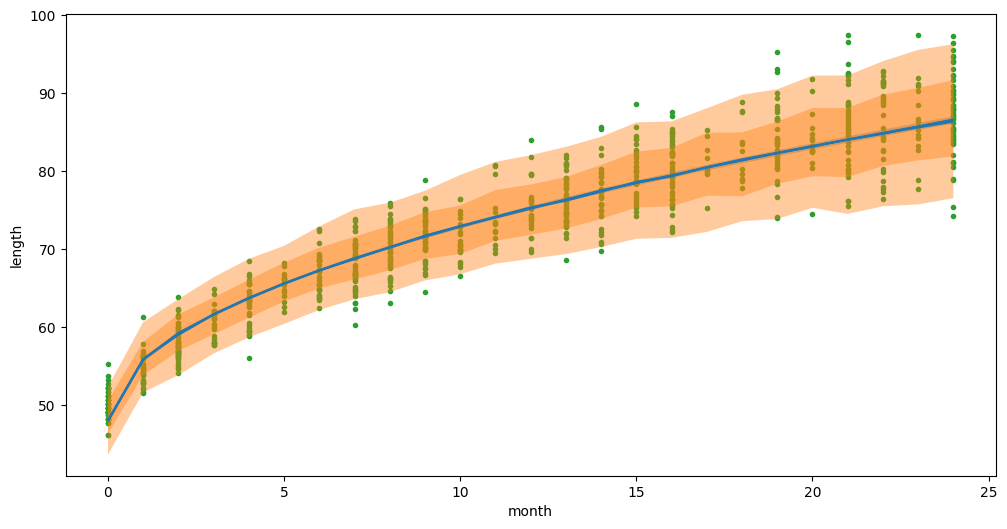

In [ ]:
#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

#raw data
ax.plot(babies.month, babies.length, "C2.", zorder=-3)

Same thing as in the previous unit. Neat.

## Categorical variables, Hierarchies, and Interactions

With the basics of multiple linear regression, bambi, and causal inference behind us, we can now look at the various ways variables can intereact. A tad confusingly, only one of these methods is called an interaction.

We'll
- see how categorical variables work with multiple linear regression
- examine hierearchies through bambi
- introduce interactions, in light of categorical variables and hierarchies.

Note: all priors will be regularizing priors, or weakly informative priors, that bambi will select based on the data itself.




### Categorical variables versus Hierarchies

Let's get back into the action with something new: creating a model with categorical variables and quantitative variables. Sepcifically, one categorical and several quantitative variables.

We'll also create a hierarchical regression with that same categorical variable, and discuss when to treat it as its own variable, and when to think of it as a hierarchy.

In [ ]:
#have to drop incomplete rows, so that bambi will run
basketball = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv').dropna()

In [ ]:
#only look at players who played more than 400 minutes
basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
basketball = basketball.query('`FT%` != 1.0')

In [ ]:
#filter out the combo positions. This will make it easier to read the graphs
basketball = basketball.query("Pos in ['C','PF','SF','SG','PG']")

In [ ]:
#define the model
model_basketball = bmb.Model("`FG%` ~ `FT%` + Pos", data=basketball)
#fit the model
idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})

Output()

ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 54, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib

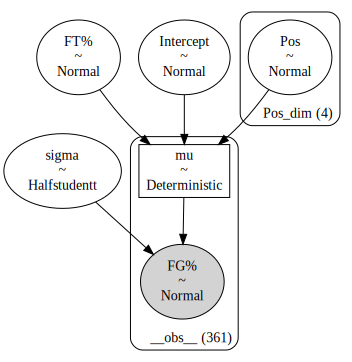

In [ ]:
model_basketball.graph()

To make that last diagram a little more readable, here's the causal diagram:

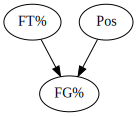

In [ ]:
dag_bball = gv.Digraph(comment='bball_dag') #bball b/c ball is life <3

dag_bball.node('G', 'FG%')
dag_bball.node('T','FT%')
dag_bball.node('P','Pos')

dag_bball.edges(['TG','PG',])

dag_bball

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FG%'>], dtype=object))

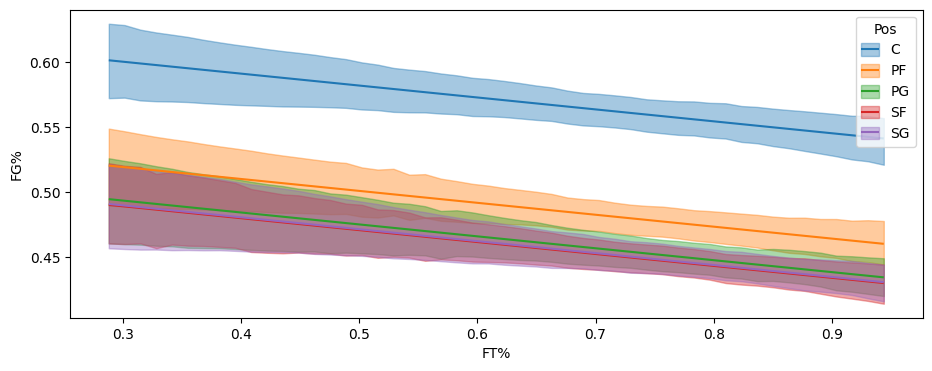

In [ ]:
#plot 94% HDIs of the means of each position
bmb.interpret.plot_predictions(model_basketball,
                               idata_basketball,
                                ["FT%",  "Pos"], fig_kwargs={"figsize":(11, 4)})

Before explaining what's going on, I'm goin to jump right in the using Pos as a hierarchy. It's slower, and there are sometimes divergences, because it a hierarchy, and hierarchies are hard to sample.

In [ ]:
#define the model, but as a hierarchy
model_basketball_h = bmb.Model("`FG%` ~ (`FT%`|Pos)", data=basketball)
#create the model
idata_basketball_h = model_basketball_h.fit(idata_kwargs={'log_likelihood': True})

Output()

ERROR:pymc.stats.convergence:There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 54, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib

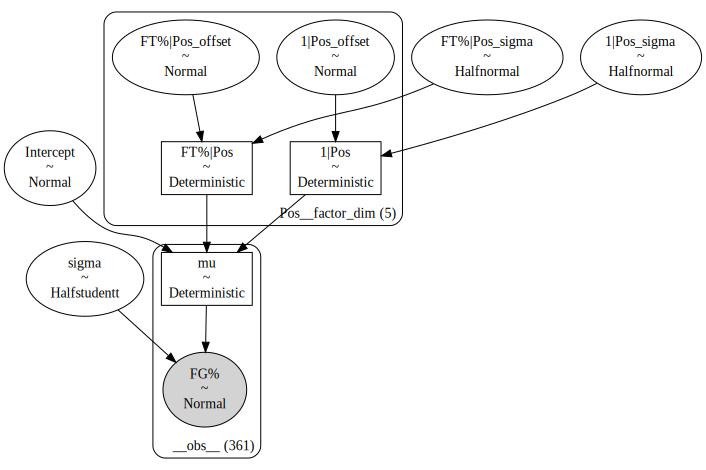

In [ ]:
model_basketball_h.graph()

And here's the causal diagram, so you can see how the variables connect

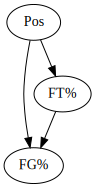

In [ ]:
dag_bballh = gv.Digraph(comment='bballh_dag') #bball hierarchy

dag_bballh.node('G', 'FG%')
dag_bballh.node('T','FT%')
dag_bballh.node('P','Pos')

dag_bballh.edges(['TG','PG','PT',])

dag_bballh

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FG%'>], dtype=object))

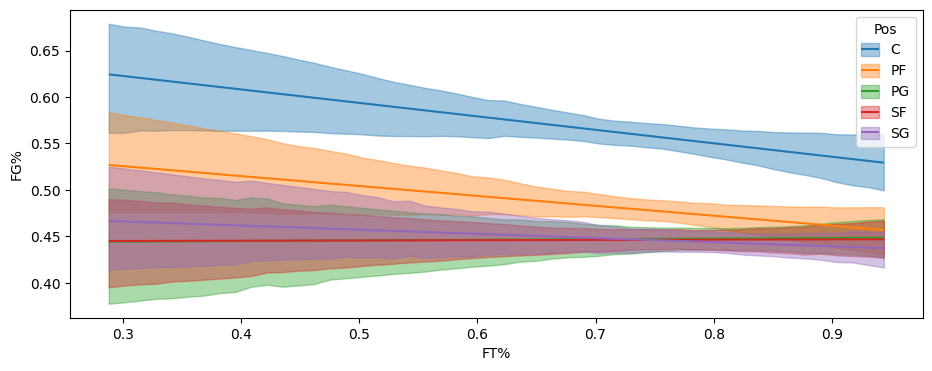

In [ ]:
bmb.interpret.plot_predictions(model_basketball_h,
                               idata_basketball_h,
                               ["FT%","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

**Task9**:

Identify and explain any similarities or differences in the plots of model_basketball and model_basketball_h.

**Answer9**:

The main difference is that the categorical variable model has the same slope for all positions, while the hierarchical model has different slopes for the different positions.

Which one's better? Depends on your contextual knowledge. You can use az.loo() and the idata objects to get and compare the elpd_loo values if you want, but this decision really should come down to what you know, and what seems to make sense.

I personally think there should be different slopes between the positions. Why? Contextual knowledge; it has something to do with the '3PA' variable.

#### Interactions

It's often the case that the effect of a predictor on the respone variable is affected by a different predictor variable.

I'll continue to use the basketball data set for this, and I'll use one example with a categorical/quantitative variable combo, and one with two quantitative variables.

In [ ]:
#define the model; bb_inter stands for baskeball interaction
model_bb_inter = bmb.Model("`FG%` ~ `FT%` + Pos + `FT%`:Pos", data=basketball)
#create the model
idata_bb_inter = model_bb_inter.fit(idata_kwargs={'log_likelihood': True})

Output()

ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 54, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib

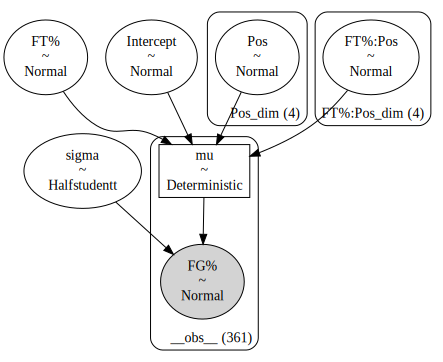

In [ ]:
model_bb_inter.graph()

Note that while the interaction model archetecture does not actually enforce the causal direction. The hiearchical model does, but often only allows for a weaker interaction.

From a causal inference perspective, the bidirectional edge (arrow) means that there is at least one unobserved confounding variable upon Pos and FT%. Whether that assumption is valid is up to us (the authors of the analysis) the determine.

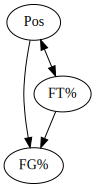

In [ ]:
dag_bballi = gv.Digraph(comment='bball_dag') #bball interaction

dag_bballi.node('G', 'FG%')
dag_bballi.node('T','FT%')
dag_bballi.node('P','Pos')

dag_bballi.edge('P', 'T', dir='both')
dag_bballi.edges(['TG','PG',])

dag_bballi

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FG%'>], dtype=object))

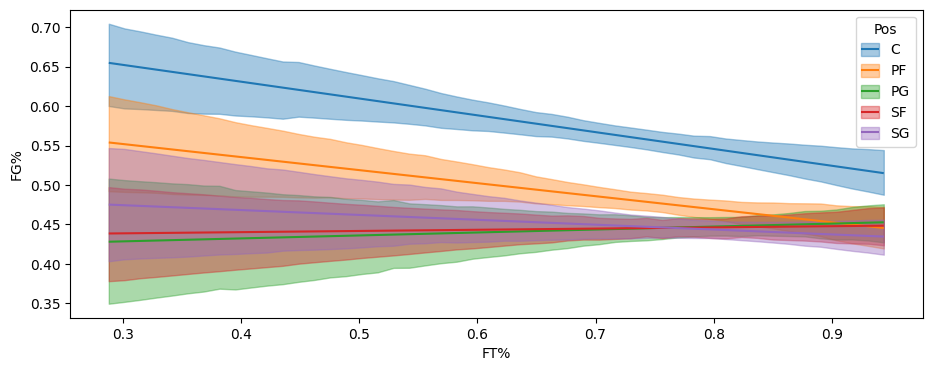

In [ ]:
bmb.interpret.plot_predictions(model_bb_inter,
                               idata_bb_inter,
                               ["FT%","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

**Task10**:

Compare this with the previous two graphs. How has the interaction affected the slope of FT% with respect to FG%?

**Answer10**:

This effect is actually similar to when we ran sepereate linear regressions for each position.

Why?

Because the interaction is picking up that FT% means something different depending on position played.

Not all interactions are as useful as this, although they can be; I more or less knew that position and FT% would have a strong interaction effect before I even downloaded the data from basketball reference dot com.

Let's do an interaction effect with all quantiative variables. For this model, I'll just replace Pos with 3PA.

In [ ]:
#define the model; bb_interq stands for baskeball interaction quantiative
model_bb_interq = bmb.Model("`FG%` ~ `FT%` + `3PA` + `FT%`:`3PA`", data=basketball)
#create the model
idata_bb_interq = model_bb_interq.fit(idata_kwargs={'log_likelihood': True})

Output()

Note that the causal structure is the same as the other interaction model, just with 3PA instead of Pos.

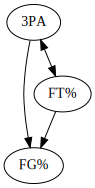

In [ ]:
dag_bballi = gv.Digraph(comment='bball_dag') #bball interaction

dag_bballi.node('G', 'FG%')
dag_bballi.node('T','FT%')
dag_bballi.node('A','3PA')

dag_bballi.edge('A', 'T', dir='both')
dag_bballi.edges(['TG','AG',])

dag_bballi

(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='FT%', ylabel='FG%'>], dtype=object))

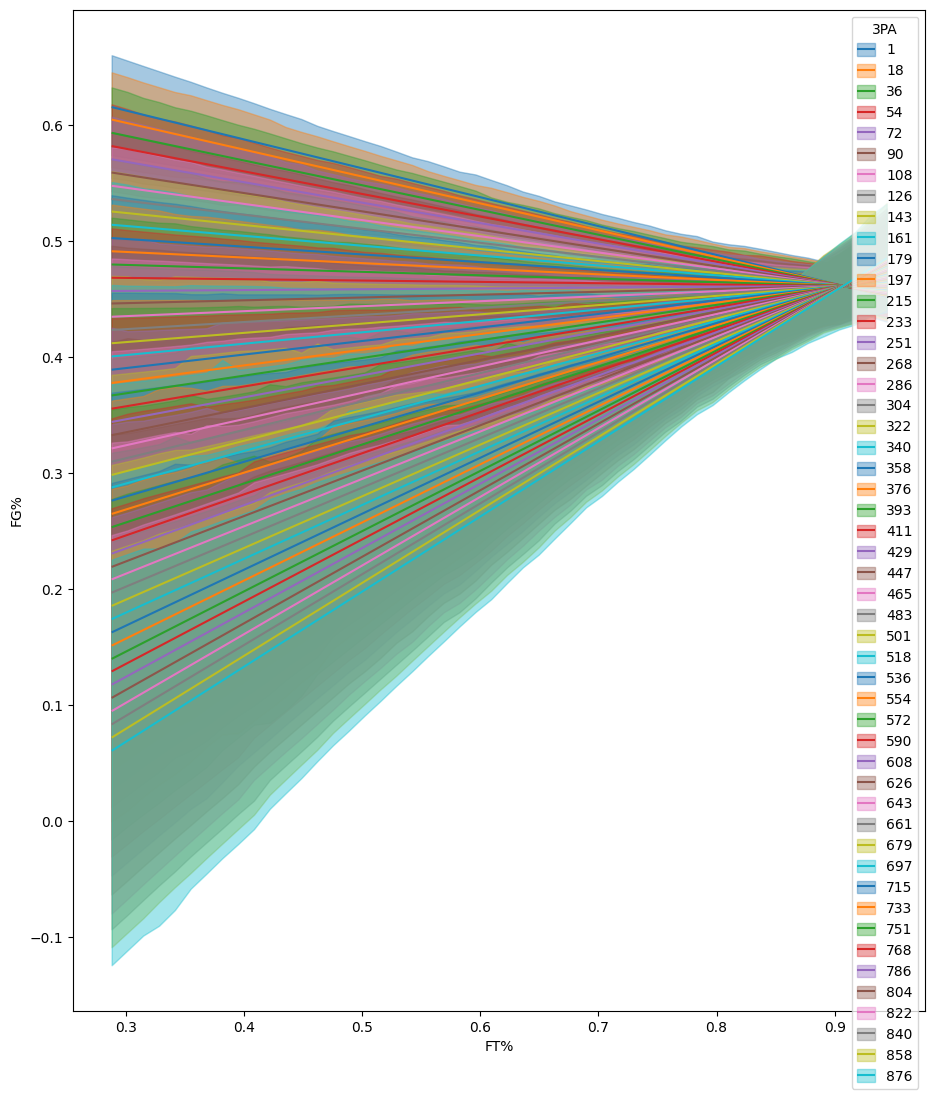

In [ ]:
bmb.interpret.plot_predictions(model_bb_interq,
                               idata_bb_interq,
                               ["FT%","3PA"],
                               fig_kwargs={"figsize":(11, 13)})#,
                               #legend=False)

**Task11**:

Using the plot above, describe the effect of 3PA on slope of FT% with respect to FG%.

**Answer11**:

The model predicts that as 3PA goes up, the slope of FT% also goes up. The effect is quite dramatic, ranging from a definitive negative slopoe, to a definite positive slope.

**Task12**:

Using the visualizations of model_bb_inter and model_bb_interq, answer the following:
1. Do centers (C) have, on average, low 3PA compared to other positions?
2. Is FT% a good predictor of FG%?

**Answer12**:

Need to Know:

1. Yep. That woud be the guess based on the models, since we now know that centers have a negative slope for FT% and FG%, and when that happens, 3PA attempts happen to be low.
2. It is, if you take 3PA attempts into account. Position played works as well.

----

Nice to Know

Really, what's going on here is that FG% includes shots from all over the court, in all manner of circumstances. FT% is basically a measure of ideallized shooting potential in a player. It's a good predictor, if you take into account more aspects of the game, especially how far a shot is going to be taken from the basket. Both 3 point attempts and position encode information about how far a player is from the basket on a given shot attempt.

## Summary

As usual, we've covered a lot of ground in one unit.

We:

- learned how to use multiple predictors at once, both in vanilla pymc and using a new library, bambi.
- saw saw how causal diagrams and a new metric called elpd_loo can help us select variables and models
- Practiced comparing and contrasting the predictions and fit of categorical variables, hierarchies, and interactions.

And now I say: congradulations! You have almost all the basics of generalized linear models at your disposal now. This is a big deal; GLMs are often a good approximation of many processes, and they are often interpretable. There's plenty more to learn, but the number of and vareity of questions you can answer has increased dramatically.

In the next unit, we'll cover the remaining basics of glms (polynomial regression, b splines) in order to give you inuition for the most powerful modeling tool of all, a tool from which nerual networks are but one instance of: Gaussian Processes.